# Midterm

Authors: Cassie Corey, Jay Zou

Tasks:
1. Read in (parse, tokenize, ...) the text (30 points)
2. Visualize the text using different interactive Bokeh visualizations (10 points of each different type of interactive visualizations - max 30).
3. Cluster the text and visualize using interactive Bokeh visualizations (10 points for each different type of interactive visualizations - max 30).
4. Explain what you've seen (10 points)

### Introduction

Our text mining and visualizations are based on the [Heavy Metal Text Mining](https://paulvanderlaken.com/2017/09/27/text-mining-pythonic-heavy-metal/) example. This example looks at multiple characteristics of the lyrics, some of which include: TFIDF, cosine distances between word distributions, emotional arcs, swearwords, and lyric generation. The characteristics were visualized using various scatter plots, graphs, trees, and word clouds.

### Required Libraries

These can all be installed with `pip install <package>`
- BeautifulSoup
- Sklearn
- Textstat

### Gathering Data

Since this example does not provide a dataset of lyrics, we collected lyrics ourselves by scraping [MetroLyrics](https://www.metrolyrics.com).

First we chose a music genre: Tech Death Metal. We got our list of bands from [Wikipedia's list of Technical Death Metal Bands](https://en.wikipedia.org/wiki/List_of_technical_death_metal_bands).

In [188]:
import requests
from bs4 import BeautifulSoup

WIKI_URL = "https://en.wikipedia.org/wiki/List_of_technical_death_metal_bands"

req = requests.get(WIKI_URL)
soup = BeautifulSoup(req.content, 'lxml')
table_cells = soup.findAll("td")

artists = []
for cell in table_cells:
    link = cell.find('a',href=True)
    if link is not None:
        if '[' not in link.text:
            artists.append(link.text.replace('(band)','').strip())

# It'll be convenient to have a lowercase version for URLs and indexing.
artists_L = [a.lower() for a in artists]

The next cell contains some useful methods that we'll need for getting urls and lyrics from urls.

In [214]:
from bs4 import BeautifulSoup
from time import sleep, time
import random, requests

BASE_URL = "http://www.metrolyrics.com/"

def get_song_urls(artists):
    art_song_dict = {}
    for artist in artists:
        url = BASE_URL + artist.replace(' ','-') + "-lyrics.html"
        sleep(random.randint(0,10))
        response = requests.get(url)
        if response.status_code != 404: # Not all artists might be on MetroLyrics
            soup = BeautifulSoup(response.content, 'lxml')
            links = [a['href'] for a in soup.find_all('a',href=True)]
            song_list = []
            for link in links:
                if "lyrics-" + artist.replace(' ','-') in link:
                    song_list.append(link)
            art_song_dict[artist] = song_list
    return art_song_dict

def get_lyrics(song_url):
    sleep(random.randint(0,10))
    response = requests.get(song_url)
    soup = BeautifulSoup(response.content, 'lxml')
    verses = soup.find_all("p",{"class":"verse"})
    lyrics = ''
    for verse in verses:
        lyrics += verse.text + ' '
#         lyrics += verse.text.replace('\n',' ') + ' '
    return lyrics

def song_from_url(song_url):
    return song_url[27:].split('lyrics')[0].replace('-',' ').strip()

_WARNING:_ THE FOLLOW CELL MAY TAKE UP TO __5 MINUTES__ TO RUN

This cell fetches urls for songs from each artist. We then use these urls to fetch the lyrics for each song.

In [215]:
t0 = time()
print('Fetching song urls...',end='')
art_song_dict = get_song_urls(artists_L)
print('Done in {:02f}s'.format(time()-t0))

Fetching song urls...

KeyboardInterrupt: 

In [217]:
import pandas as pd

# Initialize a dataframe to hold the lyrics
lyrics_df = pd.DataFrame(columns=['artist','song','lyrics'])

_WARNING:_ THE FOLLOWING CELL WILL RUN FOR A __REALLY LONG TIME__, like until the network connection times out.

This cell fetches lyrics from the song URLs. It is OK to interrupt this cell at any time if you have other business to do. As long as you save your work in the cell that follows, you can come back to this cell and it won't waste time on lyrics it has already gathered.

That said, you do still run the risk of interrupting it while it's in the middle of writing lyrics for a song. So you may get some partially complete lyrics. But you can manually check that if you're really concerned.

In [ ]:
t0 = time()
for artist in art_song_dict:
    print("Fetching lyrics for: ",artist)
    for song_url in art_song_dict[artist]:
        song = song_from_url(song_url)
        if song not in lyrics_df.song.values:
            lyrics = get_lyrics(song_url)
            lyrics_df = lyrics_df.append({'artist':artist,
                                          'song':song,
                                          'lyrics':lyrics},ignore_index=True)
print('Done in {:02f}s'.format(time()-t0))

Fetching lyrics for:  gojira
Fetching lyrics for:  monstrosity
Fetching lyrics for:  as they sleep
Fetching lyrics for:  oceano
Fetching lyrics for:  born of osiris
Fetching lyrics for:  origin
Fetching lyrics for:  extol
Fetching lyrics for:  dying fetus
Fetching lyrics for:  rings of saturn
Fetching lyrics for:  nile
Fetching lyrics for:  in battle
Fetching lyrics for:  suffocation
Fetching lyrics for:  pestilence
Fetching lyrics for:  cryptopsy
Fetching lyrics for:  obscura
Fetching lyrics for:  meshuggah
Fetching lyrics for:  death
Fetching lyrics for:  nocturnus
Fetching lyrics for:  becoming the archetype


In [213]:
# Save the lyrics data.
lyrics_df.to_csv('lyrics_line.csv')

There were some lyrics that weren't available on MetroLyrics. The following is an attempt to get the missing lyrics from another site: Genius.com.

In [182]:
def get_genius_lyrics(song,artist):
    url = "http://genius.com/{}-{}-lyrics".format(artist.replace(' ','-'),song.replace(' ','-'))
    print(url)
    response = requests.get(url)
    if response.status_code != 404:
        soup = BeautifulSoup(response.content,'lxml')
        lyrics = soup.find("div",{"class":"lyrics"})
        text = lyrics.find("p").text
#         text = lyrics.find("p").text.replace('\n',' ')
        print(text)
        return text
    return ''

In [212]:
missing_songs = lyrics_df[lyrics_df.lyrics==''].song
print("{} songs missing!".format(len(missing_songs)))

t0 = time()
for idx,song in enumerate(missing_songs):
    artist = lyrics_df.iloc[idx].artist
    lyrics = get_genius_lyrics(song,artist)
    if lyrics != '':
        lyrics_df.iloc[idx].lyrics = lyrics
print("Done in {:02f}".format(time()-t0))

# Save our work.
lyrics_df.to_csv('lyrics.csv')

166 songs missing!
http://genius.com/gojira-1990-quatrillions-de-tonnes-lyrics
http://genius.com/gojira-dawn-lyrics
[Instrumental]
http://genius.com/gojira-torii-lyrics
[Instrumental]
http://genius.com/gojira-terra-incognita-lyrics
[Instrumental]
http://genius.com/gojira-wisdom-lyrics
http://genius.com/gojira-connected-lyrics
[Instrumental]
http://genius.com/gojira-where-dragons-fall-lyrics
http://genius.com/gojira-burden-of-evil-lyrics
http://genius.com/gojira-ceremonial-void-lyrics
http://genius.com/gojira-darkest-dream-lyrics
http://genius.com/gojira-horror-infinity-lyrics
http://genius.com/gojira-immense-malignancy-lyrics
http://genius.com/gojira-imperial-doom-lyrics
http://genius.com/gojira-the-third-reich-lyrics
http://genius.com/gojira-to-the-republic-lyrics
http://genius.com/gojira-the-darkest-ages-lyrics
http://genius.com/gojira-god-of-war-lyrics
http://genius.com/gojira-attila-lyrics
http://genius.com/gojira-poseidon-lyrics
http://genius.com/gojira-oracle-of-the-dead-lyrics
h

http://genius.com/oceano-lotus-eater-lyrics
http://genius.com/oceano-silent-lyrics
http://genius.com/born-of-osiris-fidelio-lyrics
http://genius.com/born-of-osiris-dreamless-lyrics
http://genius.com/born-of-osiris-les-silence-lyrics
http://genius.com/born-of-osiris-fractal-point-lyrics
Done in 40.545631


## Loading Data

In case you didn't use the cells above to gather it.

In [2]:
import pandas as pd

# Lyrics dataframe
lyrics_df = pd.read_csv('lyrics.csv')
lyrics_df.sample(10)

,Unnamed: 0,artist,song,lyrics
474,474,suffocation,rapture of revocation,Death lies within thyself Eager to release its...
990,990,psycroptic,the labyrinth,Tumbling deep into a darkened nightmare Uncons...
841,841,revocation,only the spineless survive,Devolved wriggling monstrosities roam through ...
930,930,cephalic carnage,friend of mine,"Two years ago, a friend of mine told me to wri..."
27,27,gojira,1990 quatrillions de tonnes,NaN
374,374,nile,kheftiu asar butchiu,Kheftin Asar Butbiu Enemies of Osiris Who Are ...
193,193,origin,thrall fulcrum apex,Trials and degenerations of an upjumped demigo...
1170,1170,cynic,thinking being,Coinage of my brain A bodiless creation ecstac...
1028,1028,arsis,failing winds of hopeless greed,"So, the sight has finally left us with dreams ..."
869,869,aborted,die verzweiflung,Ich bin das Ende aller Dinge Lautlos nähernt a...


## TFIDF

Term frequency inverse document frequency (TFIDF) is a good way to visualize which words are the most descriptive of a certain corpus. We can use it to get an idea of the most descriptive words in the genre as a whole. It can also be used to distinguish between bands or distinguish which songs are the most descriptive of a band.

TFIDF treats text as a Bag of Words which means that order doesn't matter and punctuation is ignored. This is good for lyrics because punctuation is sort of a free-for-all. There may be a lot of incomplete sentences or repeated words.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_vectorizer.fit_transform(lyrics_df.dropna().lyrics)

count_vectorizer = CountVectorizer(stop_words='english',max_df=0.7)
count_vectorizer.fit_transform(lyrics_df.dropna().lyrics)

<1125x15845 sparse matrix of type '<class 'numpy.int64'>'
	with 75297 stored elements in Compressed Sparse Row format>

In [7]:
len(tfidf_vectorizer.get_feature_names())

15845

In [55]:
len(count_vectorizer.get_feature_names())

15845

In [56]:
term_frequency = zip(count_vectorizer.get_feature_names(),
                     np.asarray(X.sum(axis=0)).ravel())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

## Swear Words

The original author did not provide a full dataset of lyrics (or even the code to scrape it). He did, however, provide a list of naughty words. So, we used that to explore naughty words in the lyrics we collected.

He compared lyric complexity to the number of swearwords used and found a positive correlation. We do the same experiment below.

In [42]:
# Read in the swear words
with open('swear_words.txt','r') as f:
    swear_words = f.read().splitlines()

The original author used the SMOG measure of complexity. It estimates the reading grade level of text. However, this calculation relies on counting the number of sentences in a piece of text. Since lyrics are structured a bit differently from normal text, we might need to try a few different ways of dealing with the lack of punctuation.

In [43]:
from textstat.textstat import textstat

# From pythonic-metal github
def count_swear_word_ratio(text):
    counter = 0
    for swear_word in swear_words:
        counter += text.count(swear_word)
    number_of_words = textstat.lexicon_count(text)
    return counter/number_of_words

In [47]:
lyrics_df['swear_words_ratio'] = 0
lyrics_df['complexity'] = 0

for i,lyrics in enumerate(lyrics_df.dropna().lyrics):
    if len(lyrics)>0:
        # Calculate complexity
        complexity = textstat.smog_index(lyrics)
        lyrics_df.iloc[i,lyrics_df.columns.get_loc('complexity')] = complexity
        # Calculate swear words ratio
        swr = count_swear_word_ratio(lyrics)
        lyrics_df.iloc[i,lyrics_df.columns.get_loc('swear_words_ratio')] = swr

lyrics_df.sample(5)

,Unnamed: 0,artist,song,lyrics,complexity,swear_words_ratio
557,557,pestilence,reduce to ashes,Dark middleagess centuries of pain The appear...,8.8,0.010582
495,495,suffocation,jesus wept,NaN,7.2,0.032787
1254,1254,cannibal corpse,priests of sodom,The blackened city calls out Enter the temple ...,0.0,0.000000
1158,1158,cynic,the lions roar,Bury the bells Between two mountains The big t...,0.0,0.000000
635,635,meshuggah,sane,"Come And Hear My Twisted Lies, The Way I Bend ...",0.0,0.020833


In [49]:
# Save it if you want
lyrics_df.to_csv("lyrics_complexity_swear_words.csv")

In [57]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()
p = figure()

for a in set(lyrics_df.dropna().artist):
    x = 
    p.text(lyrics_df.loc[lyrics_df.artist==a],)

show(p, notebook_handle=True)

Loading BokehJS ...

## Cosine Distance

This measure was used to recognize band similarity and how representative certain songs were for a band. It also allowed the different bands to be clustered. We borrowed some code from the original author's notebook on [GitHub](https://github.com/ijmbarr/pythonic-metal/blob/master/pythonic-metal-part-1-counting.ipynb).

In [10]:
from scipy.spatial.distance import cosine as cs


## Clustering

Measuring band similarity based on cosine distances calculated above.

This uses scipy's linkage and dendrogram functions.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)

In [66]:
import numpy as np

def normalise(vec):
    return vec / np.dot(vec,vec)

def combine_vectors(vectors):
    return normalise(np.sum(vectors,axis=0))

lyrics_df.dropna(inplace=True)
lyrics_df["vectors_unnormalised"] = list(tfidf_vectorizer.fit_transform(lyrics_df.lyrics.values).toarray())
lyrics_df["vectors"] = lyrics_df.vectors_unnormalised.apply(normalise)

band_vectors = (
    lyrics_df
    .groupby("artist")
    .vectors
    .apply(combine_vectors)
)

<IPython.core.display.Javascript object>


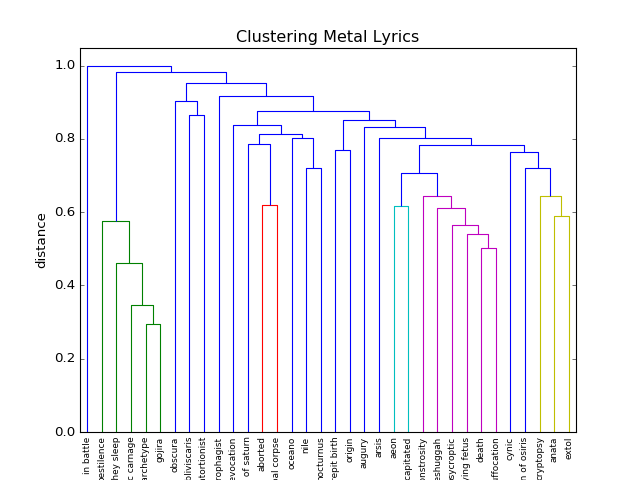

In [92]:
%matplotlib notebook

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(np.stack(list(band_vectors.values)), method='complete', metric="cosine")

n_clusters = fcluster(Z, 0.57, criterion='distance')

plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    labels=band_vectors.index.values
)

plt.title("Clustering Metal Lyrics")
plt.xticks(rotation=90)

plt.show()

In [87]:
Z

array([[  6.        ,  17.        ,   0.29572781,   2.        ],
       [  9.        ,  34.        ,   0.34678577,   3.        ],
       [  4.        ,  35.        ,   0.46093923,   4.        ],
       [ 12.        ,  32.        ,   0.50169805,   2.        ],
       [ 15.        ,  37.        ,   0.53902248,   3.        ],
       [ 29.        ,  38.        ,   0.56417412,   4.        ],
       [ 28.        ,  36.        ,   0.57590939,   5.        ],
       [  2.        ,  16.        ,   0.5907642 ,   2.        ],
       [ 19.        ,  39.        ,   0.61060893,   5.        ],
       [  1.        ,  13.        ,   0.6161181 ,   2.        ],
       [  0.        ,   8.        ,   0.6203517 ,   2.        ],
       [ 20.        ,  42.        ,   0.64379069,   6.        ],
       [ 10.        ,  41.        ,   0.64487356,   3.        ],
       [ 43.        ,  45.        ,   0.70805652,   8.        ],
       [  7.        ,  46.        ,   0.71946196,   4.        ],
       [ 23.        ,  24

In [101]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()
p = figure()

T = len(band_vectors)+1

for i in range(len(Z)):
    left = Z[i,0]
    right = Z[i,1]
    dist = Z[i,2]
    num = Z[i,3]
    if left < len(band_vectors):
        p.text(num-0.5,dist,band_vectors.index.values[left])
    else:
        p.circle(num-0.5,dist,size=5)
    if right < len(band_vectors):
        p.text(num-0.5,dist,band_vectors.index.values[left])
    
show(p, notebook_handle=True)

Loading BokehJS ...

/Users/cassiancorey/anaconda/lib/python3.5/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('text', 34), ('y', 33)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/Users/cassiancorey/anaconda/lib/python3.5/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('text', 34), ('x', 33), ('y', 33)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [103]:
len(Z)

33

## Lyric Generation

The original author built his own Markov chain class to generate lyrics. We're just going to use the Markovify library by [jsvine](https://github.com/jsvine/markovify).

Since it doesn't really make sense to generate lyrics for an entire corpus, we'll just test lyric generation on the bands that we have the most data for.

In [137]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import markovify

lyrics_df = pd.read_csv('lyrics_line.csv')
lyrics_df.dropna(inplace=True)

markov_models = {}

# build mini markov chains for each band
for band in set(lyrics_df.artist.values):
    text = ' '.join(lyrics_df.loc[lyrics_df.artist==band].lyrics.tolist())
    text = text.replace('\n','. ')
    model = markovify.Text(text)
    markov_models[band] = model
    
# n is number of sentences, k is number of characters
def output_lyrics(band,n=20,k=140):
    model = markov_models[band]
    sentences = []
    for i in range(n):
        sentences.append(model.make_short_sentence(k))
    print('\n'.join(sentences))

def update_lyrics(band):
    ouput_lyrics(band)
    push_notebook()
    
interact(output_lyrics, band=set(lyrics_df.artist.values), n=(5,40),k=(40,200))

A Jupyter Widget

<function __main__.output_lyrics>

In [125]:
output_lyrics('gojira',5)

['Leading my soul in irresponsible hands exhausted I no longer want to find and drink this light Images of the pain, you learn the lesson.',
 'Resurrected from the ashes arises.',
 'Prowling vultures in the darkest time.',
 'His words are a stair.',
 'Until the light of this world.']